In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
  dftest = adfuller(df, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

  print("----------")

  return dftest[1]

In [3]:
def correct_season(df,column,factor,T):
    clone_column = df[column]
    
    df["diff"] = clone_column - clone_column.shift(periods=T)
    df["diff_abs"] = df["diff"].apply(np.absolute)
    diff_mean = df["diff_abs"].mean()
    
    threshold_factor = factor 
    anomalies = df.loc[ ~(df["diff_abs"].isnull()) & (df["diff_abs"].dropna() > threshold_factor * diff_mean)]
    
    df["new"] = clone_column

    for i in range(len(anomalies)):
        df_od_curr = df.loc[ df["date_time"] == anomalies.iloc[i]["date_time"] ]
        df_od_prev = df.loc[df_od_curr.index -T]

        od_curr_index = df_od_curr.index[0]

        od_curr = df_od_curr.iloc[0][column]
        od_prev = df_od_prev.iloc[0][column]
        shifter = round(od_curr - od_prev , 2)

        for j in range((od_curr_index % T), od_curr_index +T, T):
            df.loc[j,"new"] += [shifter]
            
    return df["new"]

In [28]:
# datetime = pd.DataFrame(pd.date_range(start="12/01/2019 00:00",end="11/30/2020 23:50",freq="10min").rename("date_time"))
# # datetime.rename(columns={"0":"date_time"},inplace=True)
# datetime

,date_time
0,2019-12-01 00:00:00
1,2019-12-01 00:10:00
2,2019-12-01 00:20:00
3,2019-12-01 00:30:00
4,2019-12-01 00:40:00
...,...
52699,2020-11-30 23:10:00
52700,2020-11-30 23:20:00
52701,2020-11-30 23:30:00
52702,2020-11-30 23:40:00


In [29]:
# df = pd.read_csv("water.csv")
# df["date_time"] = pd.to_datetime(df["date_time"])
# # df.info()
# # df

In [24]:
# df_train = pd.read_csv("water.csv", parse_dates=["date_time"])

In [30]:
# df_train = df.drop(["date","time"],axis=1)

In [ ]:
# df_train.drop(["date","time"],axis=1,inplace=True)

In [25]:
# # df_train = df_train.resample("10T", on="date_time").mean().interpolate(method="time")
# my_order = 3
# my_s = 10
# df_train = df_train.resample("10T",on="date_time").mean().interpolate(method="spline",order=my_order,s=my_s)
# df_train.reset_index(inplace=True)
# # df_train

In [5]:
df_train = pd.read_csv("resampled_water.csv", parse_dates=["date_time"])

In [6]:
df_train.loc[df_train[df_train["water"] < -11.65].index,"water"] = -11.65
df_train.loc[df_train[df_train["water"] > 11.65].index,"water"] = 11.65

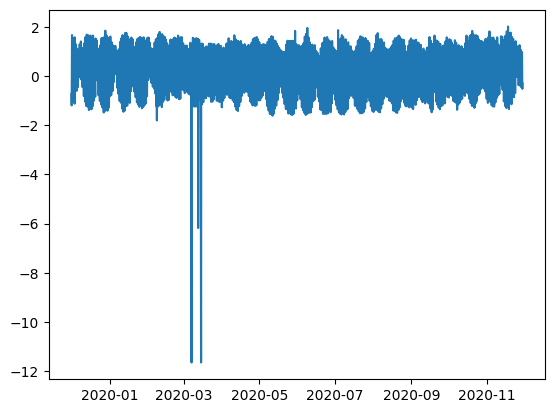

In [7]:
plt.plot(df_train["date_time"],df_train["water"])

In [27]:
# start = pd.to_datetime("12/1/2019 00:00:00", format="%m/%d/%Y %H:%M:%S")
# end = pd.to_datetime("11/29/2020 23:50:00", format="%m/%d/%Y %H:%M:%S")
# filter = (df_train["date_time"] >= start) & (df_train["date_time"] <= end)
# df_train = df_train.loc[filter]

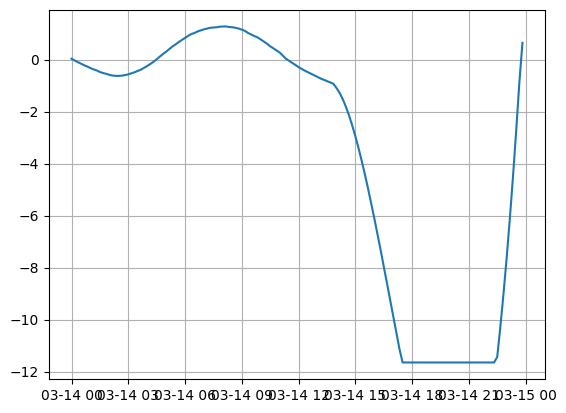

In [30]:
start = pd.to_datetime("3/14/2020 00:00:00", format="%m/%d/%Y %H:%M:%S")
end = pd.to_datetime("3/14/2020 23:50:00", format="%m/%d/%Y %H:%M:%S")
filter = (df_train["date_time"] >= start) & (df_train["date_time"] <= end)
df_filter = df_train.loc[filter]

# df_filter.reset_index(drop=True,inplace=True)
plt.plot(df_filter["date_time"],df_filter["water"])
plt.grid(True)
# plt.title('Order = '+str(my_order)+" s = "+str(my_s))

In [9]:
adf_test(df_train["water"])

1. ADF :  -30.968576302013663
2. P-Value :  0.0
3. Num Of Lags :  58
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 52501
5. Critical Values :
	 1% :  -3.4304745618132237
	 5% :  -2.8615950538210817
	 10% :  -2.566799303318103
----------


0.0

In [7]:
df_train.drop(df_train[df_train['date_time'].dt.minute != 0].index, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_train

,Unnamed: 0,date_time,water
0,0,2019-12-01 00:00:00,-0.72
1,1,2019-12-01 01:00:00,-0.97
2,2,2019-12-01 02:00:00,-1.14
3,3,2019-12-01 03:00:00,-1.17
4,4,2019-12-01 04:00:00,-0.74
...,...,...,...
8755,8755,2020-11-29 19:00:00,0.15
8756,8756,2020-11-29 20:00:00,-0.25
8757,8757,2020-11-29 21:00:00,-0.46
8758,8758,2020-11-29 22:00:00,-0.52


In [10]:
df_train["water_diff"] = df_train["water"] - df_train["water"].shift(periods=58)

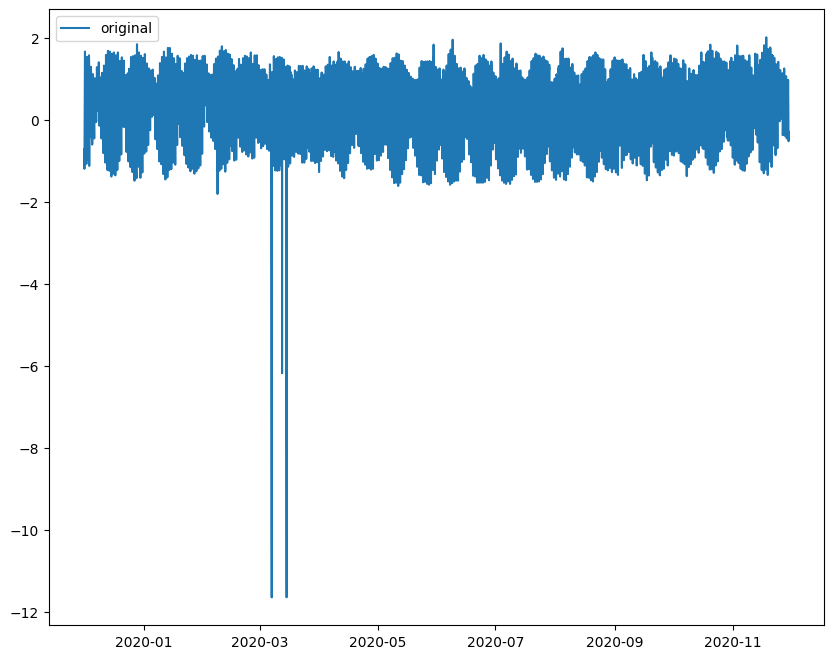

In [17]:
plt.figure(figsize=(10,8))
plt.plot(df_train["date_time"],df_train["water"], label = "original")
plt.plot(df_train["date_time"],df_train["water_diff"], label = "diff")
plt.legend()

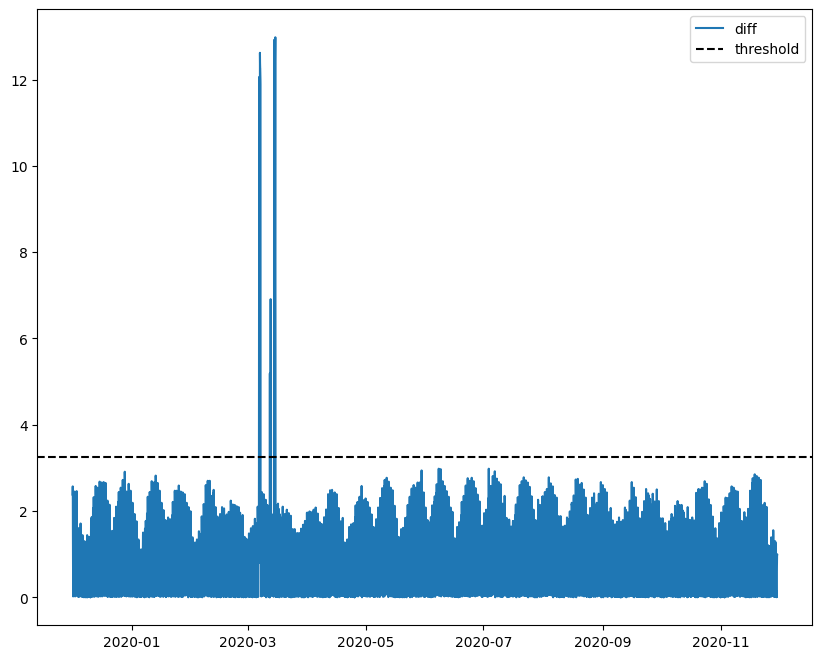

In [12]:
plt.figure(figsize=(10,8))
plt.plot(df_train["date_time"],df_train["water_diff"].abs(),label = "diff")
plt.axhline(y = df_train["water_diff"].abs().mean() * 3, color = "k", linestyle = "--", label="threshold")
plt.legend()

In [15]:
df_train["water_new"] = correct_season(df_train,"water",3,144)

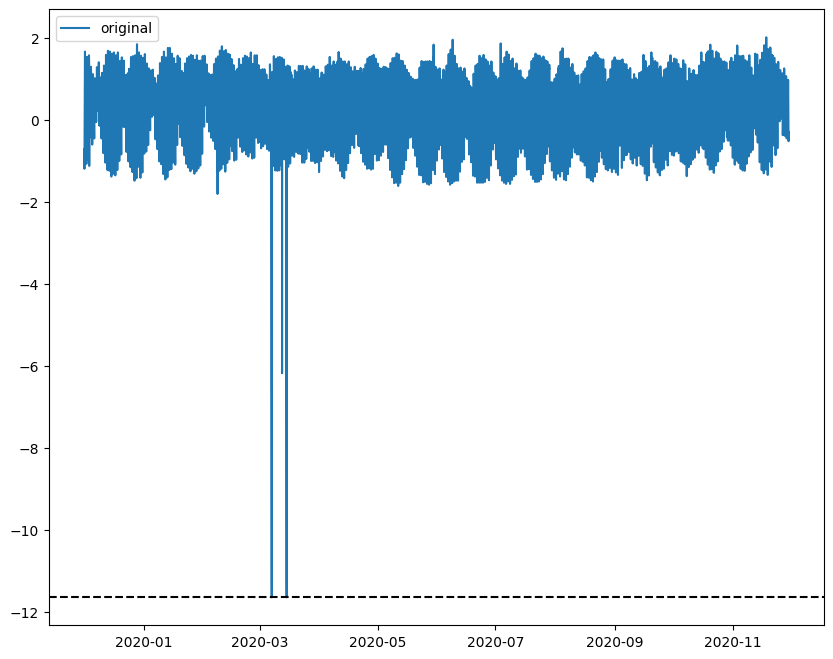

In [33]:
plt.figure(figsize=(10,8))
plt.plot(df_train["date_time"],df_train["water"],label = "original")
# plt.plot(df_train["date_time"],df_train["water_new"],label = "corrected")

plt.axhline(y = -11.65, color = "k", linestyle = "--")
# plt.axhline(y = 11.65, color = "k", linestyle = "--")
plt.legend()

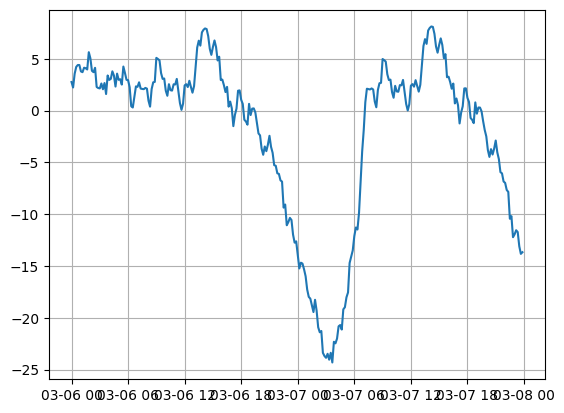

In [8]:
start = pd.to_datetime("3/6/2020 00:00:00", format="%m/%d/%Y %H:%M:%S")
end = pd.to_datetime("3/7/2020 23:50:00", format="%m/%d/%Y %H:%M:%S")
filter = (df_train["date_time"] >= start) & (df_train["date_time"] <= end)
df_filter = df_train.loc[filter]

# df_filter.reset_index(drop=True,inplace=True)
plt.plot(df_filter["date_time"],df_filter["water_new"])
plt.grid(True)
# plt.title('Order = '+str(my_order)+" s = "+str(my_s))

In [29]:
# df_train.to_csv("resampled_water.csv")